In [2]:
# Import de l'ensemble des packages nécessaires

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [3]:
df = pd.read_csv('fusion3.csv', low_memory=False)

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['Unnamed: 0','num_acc','an_nais','an_naiss','age_acc_an','num_veh','senc','occutc','permis','secuDeux','date','com'], axis=1)
df['place'] = df['place'].astype('object')
df['dep'] = df['dep'].replace({'2A':201,'2B':202})
df['dep'] = df['dep'].astype('int64')

df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291745 entries, 0 to 2291796
Data columns (total 34 columns):
 #   Column              Dtype  
---  ------              -----  
 0   place               object 
 1   catu                object 
 2   grav                object 
 3   sexe                object 
 4   trajet              object 
 5   locp                object 
 6   actp                object 
 7   etatp               object 
 8   secuUn              object 
 9   tranches_ages       object 
 10  catr                object 
 11  circ                object 
 12  nbv                 float64
 13  vosp                object 
 14  prof                object 
 15  plan                object 
 16  surf                object 
 17  infra               object 
 18  situ                object 
 19  obs                 object 
 20  obsm                object 
 21  choc                object 
 22  manv                object 
 23  catv_Label          object 
 24  lum                 obje

In [8]:
# Afficher le nombre de lignes et de colonnes
nb_lignes, nb_colonnes = df.shape
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")

Nombre de lignes : 2291745
Nombre de colonnes : 34


# Encodage et normalisation des variables

In [9]:
df['grav'] = df['grav'].astype('category')

In [10]:
valeurs_grav = df['grav'].unique()
print("Différentes valeurs de la variable 'grav':")
print(valeurs_grav)

Différentes valeurs de la variable 'grav':
['Blessé léger', 'Blessé hospitalisé', 'Indemne', 'Tué']
Categories (4, object): ['Blessé hospitalisé', 'Blessé léger', 'Indemne', 'Tué']


In [11]:
# Définition de la correspondance entre les labels et les numéros
label_mapping = {'Blessé léger': 1, 'Blessé hospitalisé': 2, 'Indemne': 0, 'Tué': 3}

# Application de la correspondance à la colonne 'grav' dans l'ensemble de données
df['grav'] = df['grav'].map(label_mapping)

df['grav'] = df['grav'].astype('category')

In [12]:
# Division du dataframe en jeu d'entraînement et jeu de test tout en maintenant la distribution des classes
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['grav'], random_state=42)

# Réduction de la taille combinée des jeux d'entraînement et de test pour pas qu'elle dépasse 20% du total 
# compte tenu du problème de mémoire du PC
max_size = 0.20 * len(df)
if len(train_df) + len(test_df) > max_size:
    # Calcul de la taille du jeu de test proportionnellement à la taille du jeu d'entraînement
    test_size = int(max_size * (len(test_df) / (len(train_df) + len(test_df))))
    test_df = df[df.index.isin(test_df.index)].sample(n=test_size, random_state=42)

# Affichage des informations sur la taille des jeux de données
print(f"Taille du jeu d'entraînement : {len(train_df)}")
print(f"Taille du jeu de test : {len(test_df)}")

Taille du jeu d'entraînement : 1833396
Taille du jeu de test : 91669


In [13]:
# Séparation des caractéristiques (X) de la variable cible (y)
X_train = train_df.drop('grav', axis=1)
y_train = train_df['grav']
X_test = test_df.drop('grav', axis=1)
y_test = test_df['grav']

In [14]:
# Affichage du type de chaque variable dans X_train
print("Types de variables dans X_train :")
print(X_train.dtypes)

# Affichage du type de la variable y_train
print("\nType de la variable y_train :")
print(y_train.dtype)

# Affichage du type de chaque variable dans X_test
print("\nTypes de variables dans X_test :")
print(X_test.dtypes)

# Affichage du type de  la variable y_test
print("\nType de la variable y_test :")
print(y_test.dtype)


Types de variables dans X_train :
place                  object
catu                   object
sexe                   object
trajet                 object
locp                   object
actp                   object
etatp                  object
secuUn                 object
tranches_ages          object
catr                   object
circ                   object
nbv                   float64
vosp                   object
prof                   object
plan                   object
surf                   object
infra                  object
situ                   object
obs                    object
obsm                   object
choc                   object
manv                   object
catv_Label             object
lum                    object
agg                    object
int                    object
atm                    object
col                    object
dep                     int64
jour_de_la_semaine     object
heure                   int64
month                   int64
day   

In [15]:
# Encodage des variables catégorielles dans les données d'entraînement
X_train_encoded = pd.get_dummies(X_train)

# Encodage des variables catégorielles dans les données de test en utilisant les colonnes de référence des données d'entraînement
X_test_encoded = pd.get_dummies(X_test, columns=X_train.columns)

# Vérification et ajout des colonnes manquantes aux données de test
missing_columns = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for column in missing_columns:
    X_test_encoded[column] = 0 

# Réorganisation des colonnes dans les données de test pour qu'elles soient dans le même ordre que celles des données d'entraînement
X_test_encoded = X_test_encoded[X_train_encoded.columns]


C:\Users\anfh\AppData\Local\Temp\ipykernel_10900\462037034.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_train_encoded = pd.get_dummies(X_train)
C:\Users\anfh\AppData\Local\Temp\ipykernel_10900\462037034.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_test_encoded = pd.get_dummies(X_test, columns=X_train.columns)


In [16]:
# Normalisation des variables numériques 
scaler = StandardScaler()
X_train_encoded[['nbv']] = scaler.fit_transform(X_train_encoded[['nbv']])
X_test_encoded[['nbv']] = scaler.transform(X_test_encoded[['nbv']])

## Application d'un modèle d'un réseau de neurones avec Keras - Architecture fixe deux couches cachées

In [17]:
# Définition d'un modèle de Deep learning à deux couches

model = Sequential()

# Ajout d'une couche dense avec une fonction d'activation relu 
model.add(Dense(128, activation='relu', input_shape=(X_train_encoded.shape[1],)))
model.add(Dropout(0.5))  # Ajoutez une couche de dropout pour régulariser le modèle

# Ajout d'une autre couche dense avec une fonction d'activation relu
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Couche de sortie avec une fonction d'activation softmax pour la classification
model.add(Dense(4, activation='softmax'))  # Ajustement du nombre de neurones au nombre de classes (4)

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Affichage d'un résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               33024     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 41540 (162.27 KB)
Trainable params: 41540 (162.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Entraînement du modèle
history = model.fit(X_train_encoded, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Évaluation du modèle sur le jeu de test
accuracy = model.evaluate(X_test_encoded, y_test)[1]
print(f"Précision sur le jeu de test : {accuracy * 100:.2f}%")

Epoch 1/10
25783/25783 [==============================] - 75s 3ms/step - loss: 0.9044 - accuracy: 0.6113 - val_loss: 0.8421 - val_accuracy: 0.6359
Epoch 2/10
25783/25783 [==============================] - 68s 3ms/step - loss: 0.8646 - accuracy: 0.6295 - val_loss: 0.8401 - val_accuracy: 0.6406
Epoch 3/10
25783/25783 [==============================] - 95s 4ms/step - loss: 0.8596 - accuracy: 0.6319 - val_loss: 0.8380 - val_accuracy: 0.6457
Epoch 4/10
25783/25783 [==============================] - 104s 4ms/step - loss: 0.8581 - accuracy: 0.6331 - val_loss: 0.8308 - val_accuracy: 0.6423
Epoch 5/10
25783/25783 [==============================] - 79s 3ms/step - loss: 0.8562 - accuracy: 0.6340 - val_loss: 0.8315 - val_accuracy: 0.6433
Epoch 6/10
25783/25783 [==============================] - 77s 3ms/step - loss: 0.8544 - accuracy: 0.6347 - val_loss: 0.8354 - val_accuracy: 0.6444
Epoch 7/10
25783/25783 [==============================] - 74s 3ms/step - loss: 0.8534 - accuracy: 0.6351 - val_loss: 

# Visualisation des performances du modèle

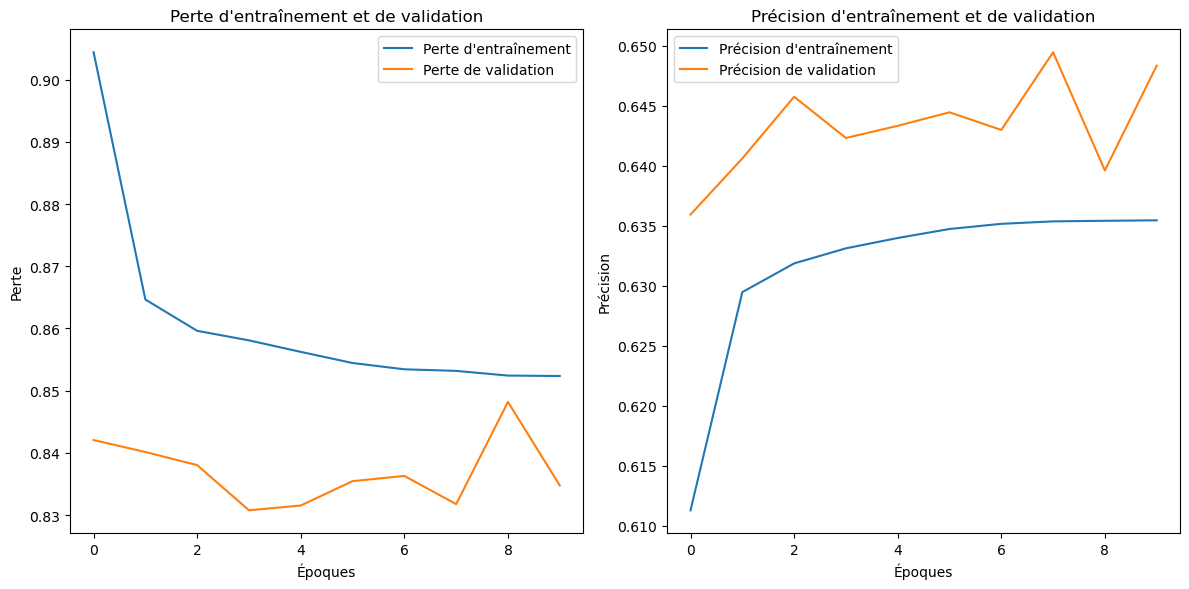

In [19]:
# Récupération des informations d'entraînement depuis l'objet history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Affichage de l'évolution de la perte
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Perte d\'entraînement')
plt.plot(validation_loss, label='Perte de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Perte d\'entraînement et de validation')
plt.legend()

# Affichage de l'évolution de la précision
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Précision d\'entraînement')
plt.plot(validation_accuracy, label='Précision de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Précision d\'entraînement et de validation')
plt.legend()

plt.tight_layout()
plt.show()


# Interprétation de la fonction de perte

Au début de l'entraînement, le modèle apprend bien à partir des données d'entraînement, ce qui se traduit par une diminution de la perte d'entraînement.

Par la suite, le modèle commence à surapprendre avec les données d'entraînement. Cela conduit à une augmentation de la perte de validation, car le modèle ne généralise pas bien sur de nouvelles données.

À la fin de l'entraînement, le modèle s'ajuste pour mieux généraliser, ce qui se traduit par une diminution de la perte de validation.

# Interprétation de la fonction de validation

Au début de l'entraînement, le modèle apprend rapidement à partir des données d'entraînement, ce qui se traduit par une augmentation rapide de la précision.
Par la suite, le modèle se stabilise, apprenant plus lentement.

Par contre, la précision de test est élevée dès le début mais avec des variations au fil des époques.

Une précision de 64,13% dès le début est encourageante et peut indiquer que le modèle tend à assez bien généraliser sur les données de test.
Les variations ultérieures (augmentations et baisses successives) peuvent être dues à des variations dans les données de test et leur poids.

Une précision de test plus élevée à la fin de l'entraînement reste encourageante, car c'est finalement la métrique qui indique la performance du modèle sur des données inconnues.

Comme les variations peuvent sembler un peu excessives, nous pourrions envisager d'explorer des techniques telles que l'early stopping pour améliorer la stabilité de l'entraînement.
Pour éviter le surapprentissage, nous pourrions aussi utiliser des techniques telles que l'ajout de régularisation (par exemple, dropout), l'augmentation de données ou ajuster d'autres hyperparamètres du modèle.

# Affichage de métriques complémentaires

Les mesures de perte et de précision sont insuffisantes pour refléter complètement la performance du modèle. 

Nous allons donc afficher : 
- La matrice de confusion pour avoir une vue détaillée des prédictions du modèle et identifier les erreurs spécifiques que le modèle commet pour la prédiction de chacune des classes.
- Le rapport de classification pour visualiser notamment le recall et la précision positive.


In [20]:
# Évaluation du modèle sur le jeu de test 
y_pred_probs = model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

2865/2865 [==============================] - 4s 1ms/step


In [21]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

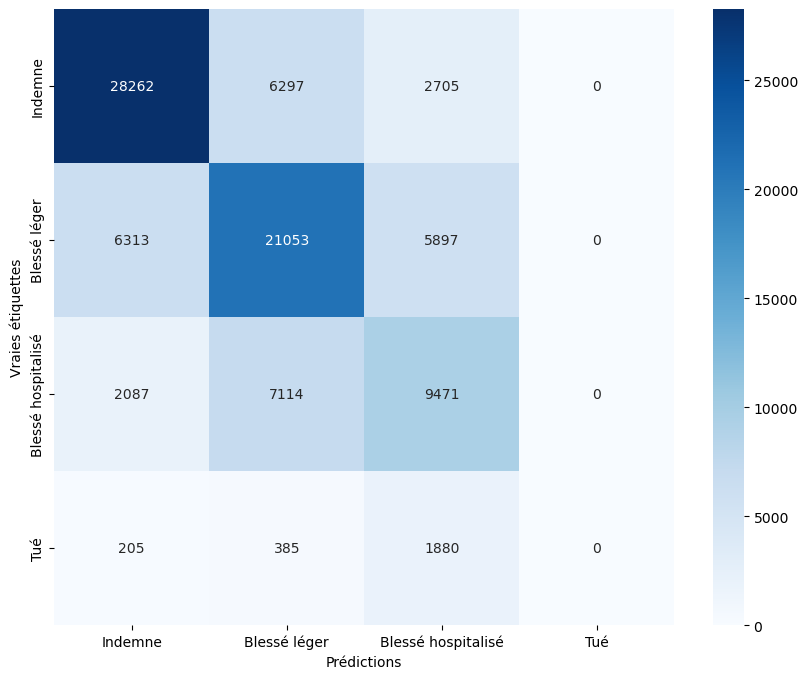

2865/2865 [==============================] - 4s 1ms/step - loss: 0.8815 - accuracy: 0.6413
Précision sur le jeu de test : 64.13%


In [22]:
# Définition des classes
classes = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']

# Affichage de la matrice de confusion 
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

# Évaluation du modèle sur le jeu de test
accuracy = model.evaluate(X_test_encoded, y_test)[1]
print(f"Précision sur le jeu de test : {accuracy * 100:.2f}%")


In [23]:
# Affichage du rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred_classes, target_names=classes))


Rapport de classification :
                     precision    recall  f1-score   support

           Indemne       0.77      0.76      0.76     37264
      Blessé léger       0.60      0.63      0.62     33263
Blessé hospitalisé       0.47      0.51      0.49     18672
               Tué       0.00      0.00      0.00      2470

          accuracy                           0.64     91669
         macro avg       0.46      0.47      0.47     91669
      weighted avg       0.63      0.64      0.63     91669



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le modèle semble bien se comporter pour les classes "Indemne" et "Blessé léger", avec des précisions et des recalls raisonnables.

Cependant, il a du mal avec la classe "Blessé hospitalisé", montrant une précision et un recall plus bas.

La classe "Tué" présente des problèmes majeurs, avec des scores de 0%, indiquant que le modèle ne parvient pas à identifier correctement cette classe.

En conclusion, le modèle montre des performances variables selon les classes. Il pourrait être utile d'explorer des techniques pour améliorer la prédiction de la classe "Tué" et éventuellement d'ajuster le modèle pour mieux traiter le déséquilibre de classe.

# Application d'un modèle d'un réseau de neurones avec Keras - Architecture flexible pour recherche d'hyperparamètres

Objectif :
Ce deuxième modèle, appliqué avec Keras Tuner, vise une exploration plus automatisée pour trouver les paramètres du modèle qui optimise la précision du modèle sur l'ensemble de validation. 

In [24]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



In [25]:
pip install keras-tuner --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Définition de la fonction modèle pour la recherche d'hyperparamètres

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train_encoded.shape[1],)))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
# Séparation des caractéristiques (X) de la variable cible (y)
X_train = train_df.drop('grav', axis=1)
y_train = train_df['grav'].squeeze() 

X_test = test_df.drop('grav', axis=1)
y_test = test_df['grav'].squeeze()  


In [28]:
# Instanciation du tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Choix du nombre d'essais
    directory='tuning_directory',
    project_name='my_model_tuning')

# Recherche des hyperparamètres 
tuner.search(X_train_encoded, y_train, epochs=10, validation_split=0.1)

# Obtention du modèle optimal
best_model = tuner.get_best_models(num_models=1)[0]

# Résumé du modèle optimal
best_model.summary()


Reloading Tuner from tuning_directory\my_model_tuning\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               57792     
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               28800     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 87108 (340.27 KB)
Trainable params: 87108 (340.27 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [29]:
# Entraînement du meilleur modèle sur l'ensemble d'entraînement complet
history = best_model.fit(X_train_encoded, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Évaluation du meilleur modèle sur le jeu de test
accuracy = best_model.evaluate(X_test_encoded, y_test)[1]
print(f"Précision sur le jeu de test : {accuracy * 100:.2f}%")

Epoch 1/10
25783/25783 [==============================] - 93s 4ms/step - loss: 0.8114 - accuracy: 0.6513 - val_loss: 0.8017 - val_accuracy: 0.6562
Epoch 2/10
25783/25783 [==============================] - 87s 3ms/step - loss: 0.8106 - accuracy: 0.6514 - val_loss: 0.8013 - val_accuracy: 0.6542
Epoch 3/10
25783/25783 [==============================] - 86s 3ms/step - loss: 0.8103 - accuracy: 0.6515 - val_loss: 0.8011 - val_accuracy: 0.6561
Epoch 4/10
25783/25783 [==============================] - 90s 4ms/step - loss: 0.8101 - accuracy: 0.6519 - val_loss: 0.8017 - val_accuracy: 0.6524
Epoch 5/10
25783/25783 [==============================] - 113s 4ms/step - loss: 0.8099 - accuracy: 0.6518 - val_loss: 0.8056 - val_accuracy: 0.6562
Epoch 6/10
25783/25783 [==============================] - 127s 5ms/step - loss: 0.8094 - accuracy: 0.6522 - val_loss: 0.8043 - val_accuracy: 0.6568
Epoch 7/10
25783/25783 [==============================] - 96s 4ms/step - loss: 0.8093 - accuracy: 0.6521 - val_loss:

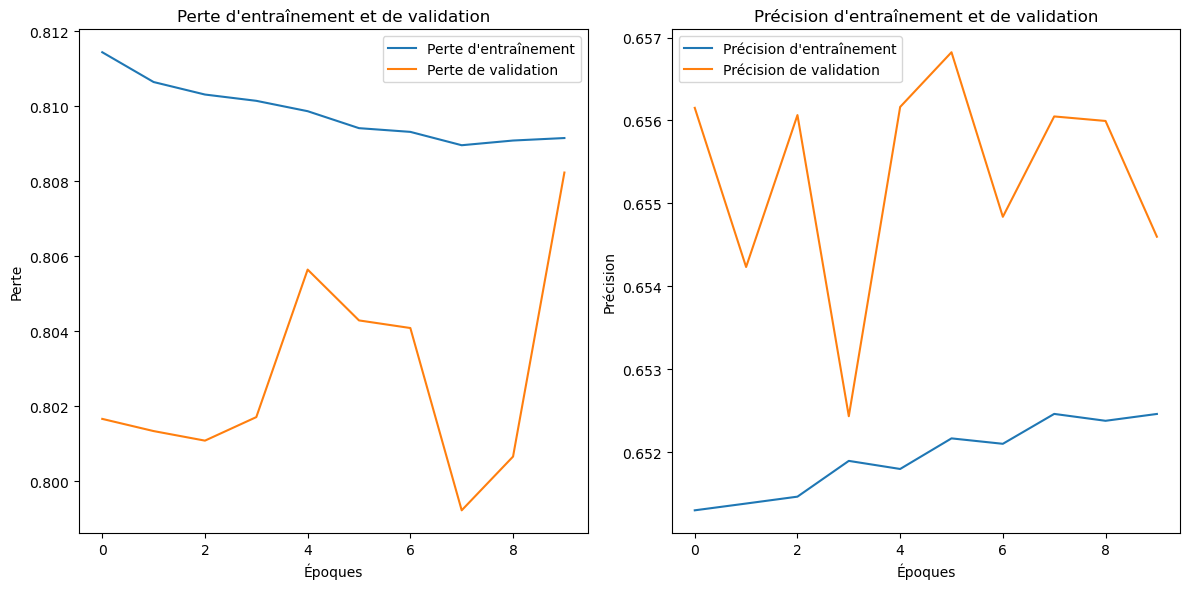

In [30]:
# Récupération des informations d'entraînement depuis l'objet history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Affichage de l'évolution de la perte
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Perte d\'entraînement')
plt.plot(validation_loss, label='Perte de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Perte d\'entraînement et de validation')
plt.legend()

# Affichage de l'évolution de la précision
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Précision d\'entraînement')
plt.plot(validation_accuracy, label='Précision de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.title('Précision d\'entraînement et de validation')
plt.legend()

plt.tight_layout()
plt.show()


Ce deuxième modèle, plus complexe que le premier compte tenu de la recherche d'hyperparamètres, ne performe pas aussi bien qu'un modèle plus simple.


# Affichage de métriques complémentaires

In [35]:
# Évaluation du meilleur modèle sur le jeu de test 
y_pred_probs = best_model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

2865/2865 [==============================] - 4s 1ms/step


In [36]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

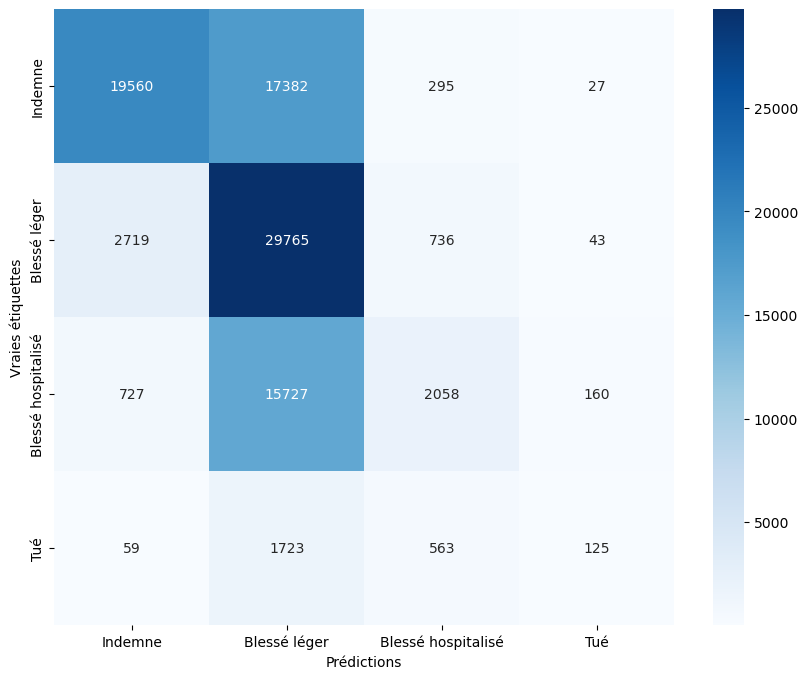

2865/2865 [==============================] - 4s 2ms/step - loss: 6.2097 - accuracy: 0.5619
Précision sur le jeu de test : 56.19%


In [37]:
# Définition des classes
classes = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']

# Affichage de la matrice de confusion 
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

# Évaluation du meilleur modèle sur le jeu de test
accuracy = best_model.evaluate(X_test_encoded, y_test)[1]
print(f"Précision sur le jeu de test : {accuracy * 100:.2f}%")

In [38]:
# Affichage du rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred_classes, target_names=classes))

Rapport de classification :
                     precision    recall  f1-score   support

           Indemne       0.85      0.52      0.65     37264
      Blessé léger       0.46      0.89      0.61     33263
Blessé hospitalisé       0.56      0.11      0.18     18672
               Tué       0.35      0.05      0.09      2470

          accuracy                           0.56     91669
         macro avg       0.56      0.40      0.38     91669
      weighted avg       0.64      0.56      0.52     91669



Malgré une diminution de la précision dans le cadre de ce deuxième modèle, ce dernier présente une amélioration des prédictions pour les classes "Tué" et "Blessé hospitalisé". 
Ces résultats suggèrent que le deuxième modèle a une meilleure capacité à prédire ces classes par rapport au premier modèle, ce qui est une amélioration positive. 